This is a notebook for creating Figure 1 of our paper so I don't have to hunt through all of my other notebooks.

In [1]:
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from pandas.plotting import table
import matplotlib.pyplot as plt
import dataframe_image as dfi
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import scienceplots


In [2]:
plt.style.use('science')

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Paired')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
colors = {'Single Domain': pal[0], 'Two-Domain': pal[1], 'Autoinhibitory': pal[3], 'Autoinhibitory (Active)': pal[2], 'Autoinhibitory (Autoinhibited)': pal[3], 
          'Full': pal[3], 'Clusters': pal[7], 'Two-State AI': pal[4], 'Autoinhibitory (Closed)': pal[5], 'Autoinhibitory (Open)': pal[4]}
pal.as_hex()

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

So we need to look at only our "exemplary" structures, aka the best structure for each protein and their states. 

In [3]:
# Load the data
cl = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')
rmsd = pd.read_csv('./project_pipeline/data/rmsds.tsv', sep='\t').astype('object')
md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t').astype('object')

cl.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.000000,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.000000,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN
2,P00523,2ptk,"148-245,246-266","81-142,521-533",1.737,100.0,89.333333,1.921,3.093,Autoinhibited,Closed,Gallus gallus,['1997-06-17'],NaN
3,P28482,1pme,173-196,"25-172,197-313",2.422,100.0,96.603774,1.220,6.639,Autoinhibited,Closed,Homo sapiens,['1998-06-08'],NaN
4,P28482,1tvo,173-196,"25-172,197-313",2.497,100.0,100.000000,1.523,6.633,Autoinhibited,Closed,Homo sapiens,['2004-06-30'],NaN


In [9]:
# We need to group by protein (uniprot) and find the minimum value of the 2_comp column

exem = cl.sort_values('2_comp').groupby('uniprot', as_index=False).first()

print(exem['conformation'].value_counts())


Closed    116
Open       12
Name: conformation, dtype: int64
1.135     1
0.807     1
0.825     1
4.391     1
25.112    1
         ..
19.893    1
2.441     1
1.765     1
3.241     1
22.071    1
Name: 2_comp, Length: 128, dtype: int64


In [5]:
# Reformat the data for plotting

# Add 1_aligned to classified files
rmsdSub = rmsd[['uniprot', 'pdb', '1_aligned']]
exem = exem.merge(rmsdSub, on=['uniprot', 'pdb'], how='left')

# Select columns of interest
clSub = exem[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
clSub.columns = ['Uniprot', 'PDB', 'Full Sequence', 'IM', 'FD', 'IM on FD']

clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']] = clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']].astype(float)

# Melt the data
plot = pd.melt(clSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
plot['RMSD'] = plot['RMSD'].astype(float)

# Remove outliers above 100 RMSD
plot = plot[plot['RMSD'] < 100]

/tmp/ipykernel_1367934/790151984.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']] = clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']].astype(float)


In [6]:
# Add in multi-domain data

md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t').astype('object')

# Subset the data
mdSub = md[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
mdSub.columns = ['Uniprot', 'PDB', 'Full Sequence', 'D1', 'D2', 'D1 on D2']

# Melt the data
mdPlot = pd.melt(mdSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
mdPlot['RMSD'] = mdPlot['RMSD'].astype(float)

In [7]:
# Add types to the dataframes
clSub['Type'] = 'Autoinhibitory'
mdSub['Type'] = 'Two-Domain'

# Rename the columns to match
clSub.columns = ['UniProt', 'PDB', 'Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2', 'Type']
mdSub.columns = ['UniProt', 'PDB', 'Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2', 'Type']

# Concatenate the dataframes
allPlot = pd.concat([clSub, mdSub])

# Melt the data
allPlot = pd.melt(allPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
allPlot['RMSD'] = allPlot['RMSD'].astype(float)

# Remove outliers
allPlot = allPlot[allPlot['RMSD'] < 100]
mdSub.head()

/tmp/ipykernel_1367934/1554477085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub['Type'] = 'Autoinhibitory'
/tmp/ipykernel_1367934/1554477085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdSub['Type'] = 'Two-Domain'


,UniProt,PDB,Full Sequence,IM/D1,FD/D2,IM on FD/D1 on D2,Type
0,D9N168,3ht3,1.115,0.883,1.153,0.979,Two-Domain
1,D9N168,4o0i,1.166,0.826,1.253,0.999,Two-Domain
2,D9N168,6ueu,1.787,0.72,2.667,1.017,Two-Domain
3,D9N168,6ur2,1.208,0.836,1.317,0.998,Two-Domain
4,D9N168,6ur4,1.208,0.842,1.275,1.073,Two-Domain


/tmp/ipykernel_1367934/3234923963.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/D1_Autoinhibitory vs. IM/D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.910e-13 U_stat=1.727e+04
Full Sequence_Autoinhibitory vs. Full Sequence_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.093e-15 U_stat=1.756e+04
FD/D2_Autoinhibitory vs. FD/D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:5.946e-16 U_stat=1.784e+04
IM on FD/D1 on D2_Autoinhibitory vs. IM on FD/D1 on D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.521e-09 U_stat=1.592e+04


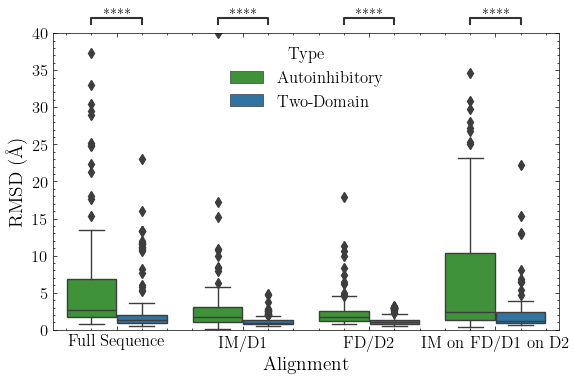

In [8]:
# Now we plot the data
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=allPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('Full Sequence', 'Autoinhibitory'), ('Full Sequence', 'Two-Domain')],
         [('IM/D1', 'Autoinhibitory'), ('IM/D1', 'Two-Domain')],
         [('FD/D2', 'Autoinhibitory'), ('FD/D2', 'Two-Domain')],
         [('IM on FD/D1 on D2', 'Autoinhibitory'), ('IM on FD/D1 on D2', 'Two-Domain')]]
subcat_order = ['Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2']
annotator = Annotator(ax, pairs, data=allPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/all_rmsd_distributions.png', dpi=500, bbox_inches='tight')